In [1]:
!pip install roboflow
#data link> https://universe.roboflow.com/roboflow-universe-projects/fire-and-smoke-segmentation/dataset/6

from roboflow import Roboflow
rf = Roboflow(api_key="4sGvq8dK2YQqFiADuN0Z") #secret key
project = rf.workspace("roboflow-universe-projects").project("fire-and-smoke-segmentation")
version = project.version(6)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...


In [2]:
dataset

In [3]:
%cd /content/Fire-and-Smoke-Segmentation-6/

/content/Fire-and-Smoke-Segmentation-6


In [4]:
!cat /content/Fire-and-Smoke-Segmentation-6/test/_annotations.coco.json

{"info":{"year":"2025","version":"6","description":"Exported from roboflow.com","contributor":"","url":"https://public.roboflow.com/object-detection/undefined","date_created":"2025-04-11T08:34:26+00:00"},"licenses":[{"id":1,"url":"https://creativecommons.org/licenses/by/4.0/","name":"CC BY 4.0"}],"categories":[{"id":0,"name":"fire-smoke","supercategory":"none"},{"id":1,"name":"fire","supercategory":"fire-smoke"},{"id":2,"name":"smoke","supercategory":"fire-smoke"}],"images":[{"id":0,"license":1,"file_name":"flare_0074_jpg.rf.aa3d148ea4d6689f69e05e44cbb15ca5.jpg","height":640,"width":640,"date_captured":"2025-04-11T08:34:26+00:00","extra":{"user_tags":["cloned-universe","fire-smoke","polygon-labels"],"name":"flare_0074.jpg"}},{"id":1,"license":1,"file_name":"flare_0199_jpg.rf.ae500cc8937e810f0a400aec85299764.jpg","height":640,"width":640,"date_captured":"2025-04-11T08:34:26+00:00","extra":{"user_tags":["cloned-universe","fire-smoke","polygon-labels"],"name":"flare_0199.jpg"}},{"id":2,"l

In [5]:
!python -m pip install pyyaml==5.1 #pyYAMl for configuratio and detectron 2 requires <= 5.1 version
import sys #access to python runtime environment
import os #file and  directory operations
import distutils.core  #used to build and install python modules from setup.py
!git clone 'https://github.com/facebookresearch/detectron2' #clones into current directory
dist = distutils.core.run_setup("./detectron2/setup.py") #programmtically runs the setup.py script inside the cloned folder
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
#install all the dependencies under install requires from the setip.py
sys.path.insert(0, os.path.abspath('./detectron2'))
#adds the absolute path of ./detectron2 to the beginning of sys path

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


W0929 16:26:22.766000 7520 torch/utils/cpp_extension.py:118] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [6]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.8 ; cuda:  cu126
detectron2: 0.6


In [7]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [8]:
#register the dataset

from detectron2.data.datasets import register_coco_instances
register_coco_instances("exp_train", {}, "/content/Fire-and-Smoke-Segmentation-6/train/_annotations.coco.json", "/content/Fire-and-Smoke-Segmentation-6/train")
register_coco_instances("exp_val", {}, "/content/Fire-and-Smoke-Segmentation-6/valid/_annotations.coco.json", "/content/Fire-and-Smoke-Segmentation-6/valid")
register_coco_instances("exp_test", {}, "/content/Fire-and-Smoke-Segmentation-6/test/_annotations.coco.json", "/content/Fire-and-Smoke-Segmentation-6/test")


WARNING [09/29 16:26:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/29 16:26:33 d2.data.datasets.coco]: Loaded 7050 images in COCO format from /content/Fire-and-Smoke-Segmentation-6/train/_annotations.coco.json


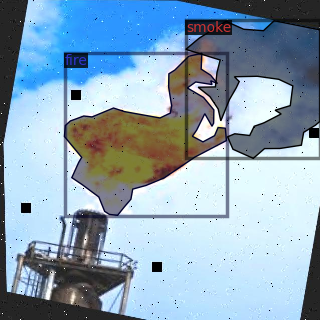

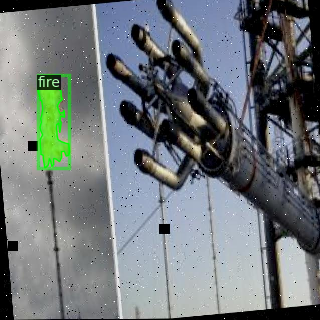

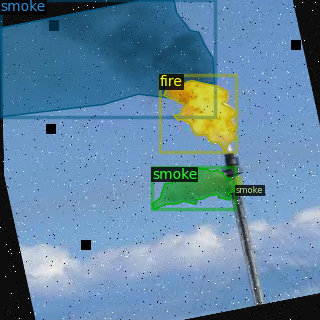

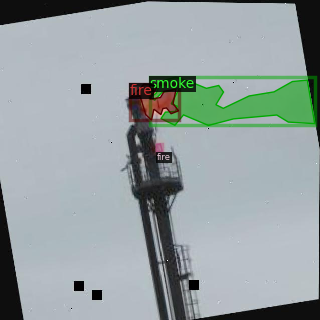

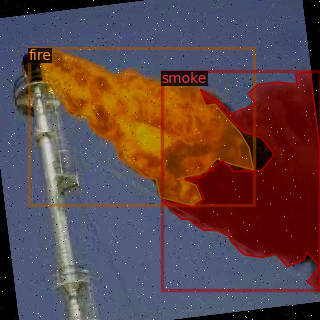

In [9]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("exp_train")
dataset_dicts = DatasetCatalog.get("exp_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [10]:
from detectron2.engine import DefaultTrainer


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("exp_train",)
cfg.DATASETS.TEST = ("exp_val",)  # optional for evaluation during training
cfg.DATALOADER.NUM_WORKERS = 2


cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")


cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005  # conservative LR for stability
cfg.SOLVER.MAX_ITER = 100   # adjust higher for practical training

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # ensure matches your dataset

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("exp_test", )
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("exp_test")


In [11]:
import torch
torch.cuda.is_available()


False

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata, # Use the correct metadata variable
                   scale=0.8,
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])